# Import dependencies

In [1]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [2]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

           Date                         Country                      Province  \
5885 2020-03-15                              UK                     Gibraltar   
5886 2020-03-15                      Uzbekistan                             -   
5887 2020-03-15                       Australia  Diamond Princess cruise ship   
5888 2020-03-15                              US                 West Virginia   
5889 2020-03-15  occupied Palestinian territory                             -   

      Infected  Deaths  Recovered  
5885         0       0          1  
5886         1       0          0  
5887         0       0          0  
5888         0       0          0  
5889         0       0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5890 entries, 0 to 5889
Data columns (total 6 columns):
Date         5890 non-null datetime64[ns]
Country      5890 non-null object
Province     5890 non-null object
Infected     5890 non-null int64
Deaths       5890 non-null int64
Recovered    58

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

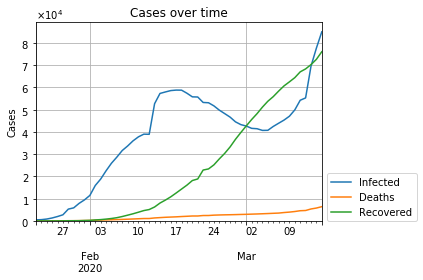

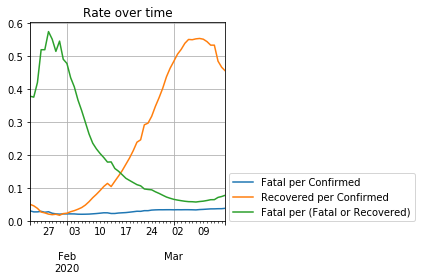

In [3]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

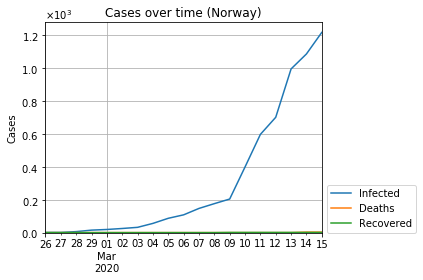

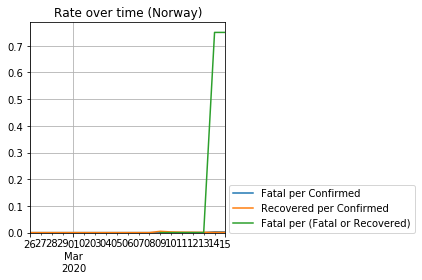

In [4]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [5]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

## The SIR epidemic model

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

 * $S(t)$: Susceptible       (= All - Confirmed)
 * $I(t)$: Infected          (= Confirmed - Recovered - Deaths)
 * $R(t)$: Recovered or Died (= Recovered + Deaths)
 
 

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 

* $\beta$ describes the effective contact rate of the disease: an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$). 

* $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:


$$\frac{dS}{dT}=\frac{-\beta}{N}SI$$

$$\frac{dI}{dT}=\frac{\beta SI}{N}-\gamma I$$

$$\frac{dR}{dT}=\gamma I$$

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

<a href="https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/">Sample code</a>


## Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$$\frac{dx}{dt}= - \rho x y$$  
$$\frac{dy}{dt}= \rho x y - \sigma y$$  
$$\frac{dz}{dt}= \sigma y$$

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

In [6]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 76320]


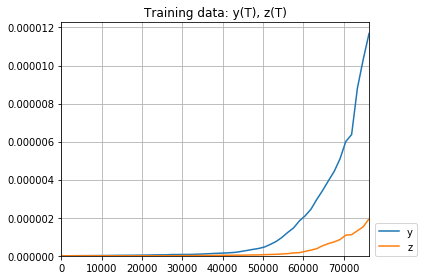

In [7]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [8]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [9]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 8.1 ms, sys: 0 ns, total: 8.1 ms
Wall time: 10.4 ms


,t,x,y,z
296,296,0.108343,0.000628,0.891029
297,297,0.108330,0.000592,0.891078
298,298,0.108317,0.000559,0.891124
299,299,0.108306,0.000527,0.891167
300,300,0.108295,0.000497,0.891208


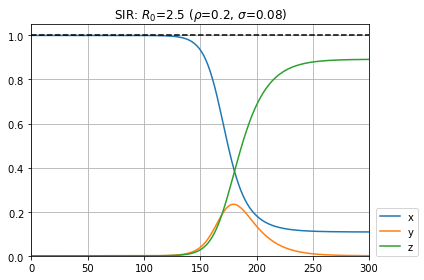

In [10]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [11]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-03-17 00:22:58,612] Finished trial#2 resulted in value: 9155288568.559479. Current best value is 9155288568.559479 with parameters: {'tau': 1402, 'rho': 0.15812060270118042, 'sigma': 0.012108699151684232}.
[I 2020-03-17 00:22:58,680] Finished trial#0 resulted in value: 8717361030.953506. Current best value is 8717361030.953506 with parameters: {'tau': 601, 'rho': 0.07669714406396017, 'sigma': 0.009170173176113709}.
[I 2020-03-17 00:22:58,766] Finished trial#1 resulted in value: 8849631603.46621. Current best value is 8717361030.953506 with parameters: {'tau': 601, 'rho': 0.07669714406396017, 'sigma': 0.009170173176113709}.
[I 2020-03-17 00:22:58,891] Finished trial#3 resulted in value: 9571924349.789988. Current best value is 8717361030.953506 with parameters: {'tau': 601, 'rho': 0.07669714406396017, 'sigma': 0.009170173176113709}.
[I 2020-03-17 00:22:59,023] Finished trial#6 resulted in value: 9902885964.451426. Current best value is 8717361030.953506 with parameters: {'tau': 

[I 2020-03-17 00:23:08,428] Finished trial#76 resulted in value: 4652418118.058569. Current best value is 4102608888.039087 with parameters: {'tau': 1436, 'rho': 0.19714309556450169, 'sigma': 0.0251224531386369}.
[I 2020-03-17 00:23:08,559] Finished trial#78 resulted in value: 4564442491.610597. Current best value is 4102608888.039087 with parameters: {'tau': 1436, 'rho': 0.19714309556450169, 'sigma': 0.0251224531386369}.
[I 2020-03-17 00:23:08,642] Finished trial#77 resulted in value: 4248363749.426261. Current best value is 4102608888.039087 with parameters: {'tau': 1436, 'rho': 0.19714309556450169, 'sigma': 0.0251224531386369}.
[I 2020-03-17 00:23:08,820] Finished trial#79 resulted in value: 4581802311.813492. Current best value is 4102608888.039087 with parameters: {'tau': 1436, 'rho': 0.19714309556450169, 'sigma': 0.0251224531386369}.
[I 2020-03-17 00:23:08,954] Finished trial#80 resulted in value: 4293428172.7147593. Current best value is 4102608888.039087 with parameters: {'tau'

[I 2020-03-17 00:23:19,597] Finished trial#153 resulted in value: 4073064285.4421244. Current best value is 3951553169.7737517 with parameters: {'tau': 1371, 'rho': 0.1944063015129627, 'sigma': 0.023842709456531327}.
[I 2020-03-17 00:23:19,745] Finished trial#149 resulted in value: 4259347798.195489. Current best value is 3951553169.7737517 with parameters: {'tau': 1371, 'rho': 0.1944063015129627, 'sigma': 0.023842709456531327}.
[I 2020-03-17 00:23:19,854] Finished trial#151 resulted in value: 5384521468.476989. Current best value is 3951553169.7737517 with parameters: {'tau': 1371, 'rho': 0.1944063015129627, 'sigma': 0.023842709456531327}.
[I 2020-03-17 00:23:19,932] Finished trial#154 resulted in value: 4063293829.433766. Current best value is 3951553169.7737517 with parameters: {'tau': 1371, 'rho': 0.1944063015129627, 'sigma': 0.023842709456531327}.
[I 2020-03-17 00:23:20,023] Finished trial#155 resulted in value: 4212738791.0447636. Current best value is 3951553169.7737517 with par

[I 2020-03-17 00:23:28,631] Finished trial#226 resulted in value: 4592965073.885128. Current best value is 3950624107.4157014 with parameters: {'tau': 1371, 'rho': 0.19415424854667604, 'sigma': 0.02408114376165255}.
[I 2020-03-17 00:23:28,723] Finished trial#228 resulted in value: 4402453455.733876. Current best value is 3950624107.4157014 with parameters: {'tau': 1371, 'rho': 0.19415424854667604, 'sigma': 0.02408114376165255}.
[I 2020-03-17 00:23:28,937] Finished trial#227 resulted in value: 4356902542.707604. Current best value is 3950624107.4157014 with parameters: {'tau': 1371, 'rho': 0.19415424854667604, 'sigma': 0.02408114376165255}.
[I 2020-03-17 00:23:29,216] Finished trial#229 resulted in value: 4133036850.115075. Current best value is 3950624107.4157014 with parameters: {'tau': 1371, 'rho': 0.19415424854667604, 'sigma': 0.02408114376165255}.
[I 2020-03-17 00:23:29,299] Finished trial#230 resulted in value: 4527885517.087234. Current best value is 3950624107.4157014 with param

[I 2020-03-17 00:23:39,484] Finished trial#302 resulted in value: 4276692541.2535214. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:39,579] Finished trial#303 resulted in value: 4665527851.54528. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:39,754] Finished trial#305 resulted in value: 4358525580.261474. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:39,881] Finished trial#304 resulted in value: 4478685037.880357. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:40,013] Finished trial#291 resulted in value: 10428871393.148829. Current best value is 3907646715.3764462 with paramete

[I 2020-03-17 00:23:51,662] Finished trial#377 resulted in value: 4892416331.350614. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:51,814] Finished trial#378 resulted in value: 4397980929.421388. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:51,917] Finished trial#379 resulted in value: 3967003411.6103897. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:52,042] Finished trial#380 resulted in value: 4063435851.510402. Current best value is 3907646715.3764462 with parameters: {'tau': 1406, 'rho': 0.19587165248715155, 'sigma': 0.0253205167576809}.
[I 2020-03-17 00:23:52,210] Finished trial#382 resulted in value: 3810669048.662666. Current best value is 3810669048.662666 with parameter

[I 2020-03-17 00:24:02,932] Finished trial#452 resulted in value: 4276976901.3713164. Current best value is 3810669048.662666 with parameters: {'tau': 1406, 'rho': 0.19742275097564968, 'sigma': 0.024515226912171683}.
[I 2020-03-17 00:24:03,133] Finished trial#453 resulted in value: 4286446417.8973765. Current best value is 3810669048.662666 with parameters: {'tau': 1406, 'rho': 0.19742275097564968, 'sigma': 0.024515226912171683}.
[I 2020-03-17 00:24:03,244] Finished trial#454 resulted in value: 4126053065.0012007. Current best value is 3810669048.662666 with parameters: {'tau': 1406, 'rho': 0.19742275097564968, 'sigma': 0.024515226912171683}.
[I 2020-03-17 00:24:03,433] Finished trial#455 resulted in value: 4216598025.550393. Current best value is 3810669048.662666 with parameters: {'tau': 1406, 'rho': 0.19742275097564968, 'sigma': 0.024515226912171683}.
[I 2020-03-17 00:24:03,548] Finished trial#456 resulted in value: 4222499754.456495. Current best value is 3810669048.662666 with par

CPU times: user 1min 11s, sys: 3.7 s, total: 1min 14s
Wall time: 1min 12s


/home/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



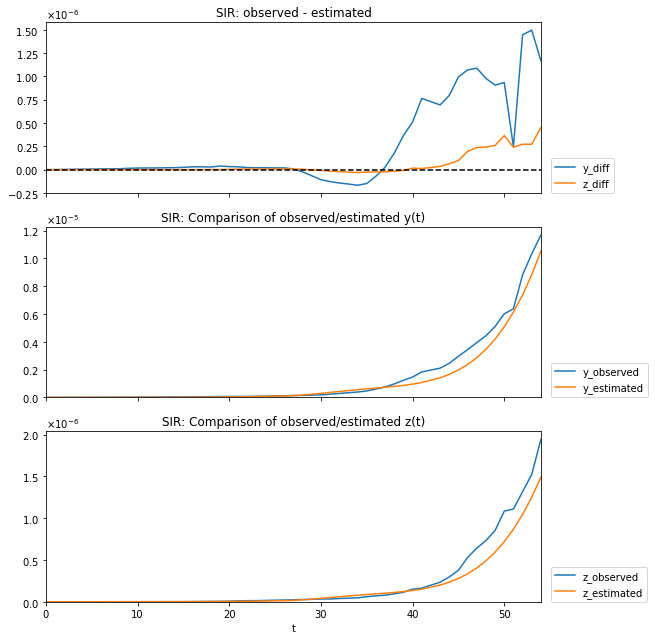

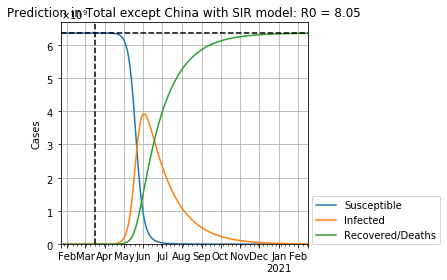

In [12]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [13]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-03-17 00:24:12,975] Finished trial#2 resulted in value: 116841044431.66946. Current best value is 116841044431.66946 with parameters: {'tau': 245, 'kappa': 0.0006582659648004626, 'rho': 0.023785546322021126, 'sigma': 0.0011861078101255528}.
[I 2020-03-17 00:24:13,050] Finished trial#3 resulted in value: 102891314160.93149. Current best value is 102891314160.93149 with parameters: {'tau': 415, 'kappa': 0.00046438219699089945, 'rho': 0.044727025764137715, 'sigma': 0.004945715107857021}.
[I 2020-03-17 00:24:13,122] Finished trial#0 resulted in value: 174397092544.62146. Current best value is 102891314160.93149 with parameters: {'tau': 415, 'kappa': 0.00046438219699089945, 'rho': 0.044727025764137715, 'sigma': 0.004945715107857021}.
[I 2020-03-17 00:24:13,213] Finished trial#4 resulted in value: 175992294740.77478. Current best value is 102891314160.93149 with parameters: {'tau': 415, 'kappa': 0.00046438219699089945, 'rho': 0.044727025764137715, 'sigma': 0.004945715107857021}.
[I 2

[I 2020-03-17 00:24:21,414] Finished trial#67 resulted in value: 47881055370.65033. Current best value is 44910558795.971176 with parameters: {'tau': 1440, 'kappa': 0.0029961043763701042, 'rho': 0.19736274188220979, 'sigma': 0.021180445987362337}.
[I 2020-03-17 00:24:21,589] Finished trial#69 resulted in value: 112139630958.38515. Current best value is 44910558795.971176 with parameters: {'tau': 1440, 'kappa': 0.0029961043763701042, 'rho': 0.19736274188220979, 'sigma': 0.021180445987362337}.
[I 2020-03-17 00:24:21,782] Finished trial#70 resulted in value: 55528976812.8077. Current best value is 44910558795.971176 with parameters: {'tau': 1440, 'kappa': 0.0029961043763701042, 'rho': 0.19736274188220979, 'sigma': 0.021180445987362337}.
[I 2020-03-17 00:24:21,922] Finished trial#57 resulted in value: 120080638940.908. Current best value is 44910558795.971176 with parameters: {'tau': 1440, 'kappa': 0.0029961043763701042, 'rho': 0.19736274188220979, 'sigma': 0.021180445987362337}.
[I 2020-0

[I 2020-03-17 00:24:31,665] Finished trial#133 resulted in value: 86697756874.41354. Current best value is 43480899772.84323 with parameters: {'tau': 1440, 'kappa': 0.0018180845150498808, 'rho': 0.19726142528036913, 'sigma': 0.020286898597648963}.
[I 2020-03-17 00:24:31,778] Finished trial#132 resulted in value: 57916814272.78235. Current best value is 43480899772.84323 with parameters: {'tau': 1440, 'kappa': 0.0018180845150498808, 'rho': 0.19726142528036913, 'sigma': 0.020286898597648963}.
[I 2020-03-17 00:24:31,928] Finished trial#134 resulted in value: 45086020729.47603. Current best value is 43480899772.84323 with parameters: {'tau': 1440, 'kappa': 0.0018180845150498808, 'rho': 0.19726142528036913, 'sigma': 0.020286898597648963}.
[I 2020-03-17 00:24:32,126] Finished trial#135 resulted in value: 44731091570.85758. Current best value is 43480899772.84323 with parameters: {'tau': 1440, 'kappa': 0.0018180845150498808, 'rho': 0.19726142528036913, 'sigma': 0.020286898597648963}.
[I 2020-

[I 2020-03-17 00:24:42,135] Finished trial#199 resulted in value: 55977620524.88819. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:42,290] Finished trial#198 resulted in value: 76184877209.887. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:42,460] Finished trial#200 resulted in value: 55222638008.107056. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:42,576] Finished trial#202 resulted in value: 46425275780.6248. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:2

[I 2020-03-17 00:24:53,358] Finished trial#262 resulted in value: 47663267744.63614. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:53,551] Finished trial#265 resulted in value: 44077254522.978806. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:53,712] Finished trial#266 resulted in value: 46485597337.582695. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:24:53,851] Finished trial#268 resulted in value: 43359310627.1941. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 0

[I 2020-03-17 00:25:06,475] Finished trial#330 resulted in value: 43482210708.79407. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:06,608] Finished trial#329 resulted in value: 43603833235.18066. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:06,744] Finished trial#331 resulted in value: 49074670079.80565. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:06,945] Finished trial#332 resulted in value: 45925570511.77287. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00

[I 2020-03-17 00:25:19,459] Finished trial#397 resulted in value: 103935388179.00278. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:19,597] Finished trial#398 resulted in value: 64956414398.546196. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:19,852] Finished trial#400 resulted in value: 54782271491.53043. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:19,990] Finished trial#399 resulted in value: 60186129904.90392. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 

[I 2020-03-17 00:25:32,890] Finished trial#446 resulted in value: 106385065635.19939. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:33,033] Finished trial#464 resulted in value: 52682881109.21091. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:33,264] Finished trial#463 resulted in value: 98691407323.094. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:25:33,464] Finished trial#465 resulted in value: 46975622245.80768. Current best value is 40700458315.2171 with parameters: {'tau': 1406, 'kappa': 0.0016497181169081207, 'rho': 0.19571093663132413, 'sigma': 0.02014930170162647}.
[I 2020-03-17 00:

CPU times: user 1min 26s, sys: 5.14 s, total: 1min 31s
Wall time: 1min 27s


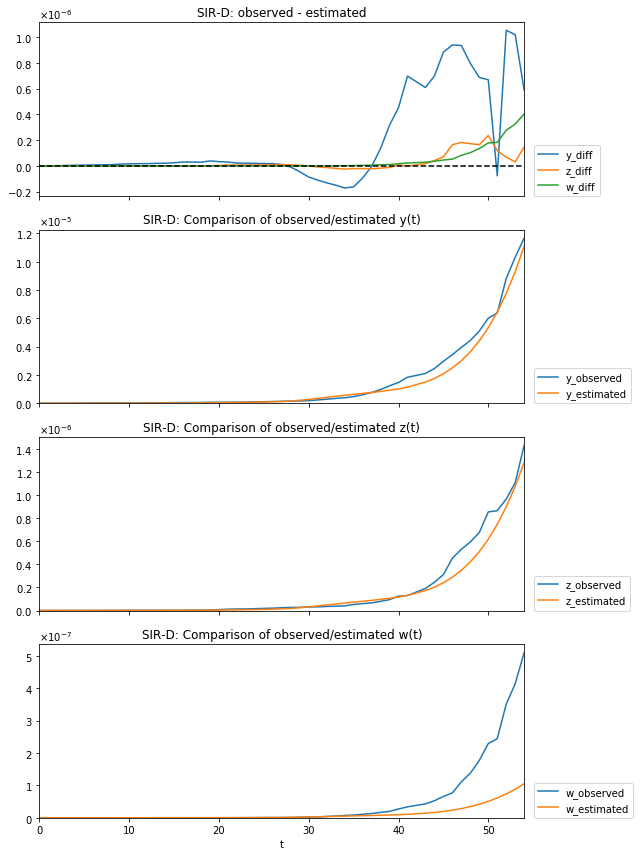

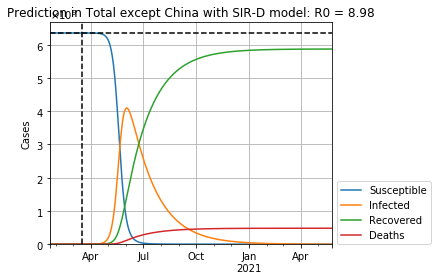

In [14]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

# References

Further Reading

* M. J. Keeling and P. Rohani, <a href="http://press.princeton.edu/titles/8459.html">Modeling Infectious Diseases in Humans and Animals</a>, Princeton (2007).
* R. M. Anderson and R. M. May, <a href="http://www.amazon.co.uk/Infectious-Diseases-Humans-Dynamics-Publications/dp/019854040X">Infectious Diseases of Humans: Dynamics and Control,</a> OUP (1992).